In [1]:
from common_funcs import * # imports things like pandas, etc.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def full_print(x):
    return print_full(x)

Import Ecuador poverty data set

In [3]:
df = pd.read_csv('data/train.csv', index_col=0)

In [4]:
# Look for columns with lots of null values
df.isna().sum().sort_values(ascending=False)

rez_esc            7928
v18q1              7342
v2a1               6860
SQBmeaned             5
meaneduc              5
                   ... 
abastaguafuera        0
abastaguadentro       0
cielorazo             0
techootro             0
Target                0
Length: 142, dtype: int64

There are three columns with tons of null values. Let's just drop. Let's also drop the columns with squared values. That seems redundant.

In [5]:
df = df.drop(columns=['rez_esc', 'v18q1', 'v2a1','SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                      'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'], errors='ignore')

# Exploratory Data Analysis

What is the breakdown of poverty by household? That is, how many households within each category?

In the below bar chart, the poverty category is averaged by household. Because of errors in the data, some individuals in some households are marked as having a different poverty category than others in the same household. For the purposes of this preliminary EDA, the poverty category is simply averaged and rounded to the nearest whole number.

Since Category 1 is the most important to identify correctly, the bar chart suggests the classes are imbalanced.

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

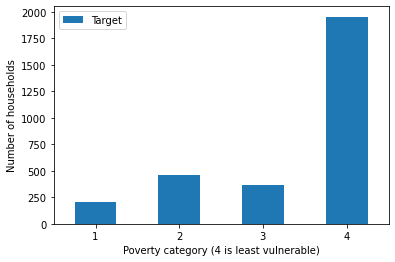

In [18]:
target_data = df.groupby('idhogar')['Target'].mean().value_counts()
target_data.index = list(map(round, list(target_data.index))) # round Target to nearest whole number
target_data.reset_index().groupby('index').sum().plot(kind='bar')
plt.xlabel('Poverty category (4 is least vulnerable)')
plt.ylabel('Number of households')
plt.xticks(rotation=0)

# Cleaning
## Clean up Dependency column

Dependency seems like it could be important. This is defined as the number of adults divided by the number of children and elderly. Higher dependency could suggest greater poverty. This column contains a mixture of strings ('yes', 'no') and floats. Replace 'no' with 0 and 'yes' with the average of the other points PER POVERTY CATEGORY. As you can see below, 'yes', and 'no' are about 40% of the values for this column.

In [27]:
(df.dependency.value_counts()/df.dependency.count()).head()

yes    0.229361
no     0.182798
.5     0.156639
2      0.076384
1.5    0.074605
Name: dependency, dtype: float64

In [28]:
df.dependency = df.dependency.str.replace('no', '0')

In [29]:
# The non-yes values must be converted to floats to calculate mean.
dep_df = df[df.dependency != 'yes']
dep_df.dependency = dep_df.dependency.astype('float')
dep_means = dep_df.groupby('Target')['dependency'].mean()
dep_means

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Target
1    1.869565
2    1.820175
3    1.493852
4    0.889393
Name: dependency, dtype: float64

In [30]:
dep_means.loc[1]

1.869565218405797

In [31]:
def replace_yes(df):
    if df['dependency'] == 'yes':
        for i in range(1, 5):
            if df['Target'] == i:
                return dep_means.loc[i]
    else:
        return df.dependency

In [32]:
df.dependency = df.apply(replace_yes, axis=1).astype('float')

## Clean up Target column

When analyzing data, it makes sense to analyze by household (idhogar) because it wouldn't make sense that one person is poor but the rest of his household is not. So what we'll do is modify the df so that each person's poverty category is the mean of his household's but rounded to the nearest whole number.

In [34]:
# What happens here is the df is grouped by household, the Target is averaged and rounded, and merged back into 
# the original df
df = df.drop('Target', axis=1).merge(df.groupby('idhogar')['Target'].mean().map(round), on='idhogar')

# Back to some EDA
Does the household size affect poverty? Maybe larger households are more likely to be poor?

In [36]:
data = df.groupby('idhogar')[['tamhog', 'Target']].mean().groupby('Target').mean()
data.index = list(map(round, list(data.index)))

Text(0, 0.5, 'Number of households')

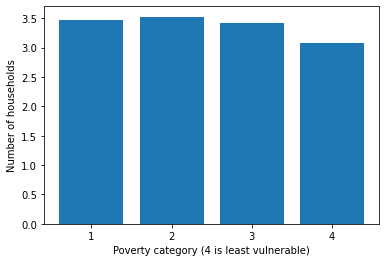

In [37]:
plt.bar(data.index, data.tamhog)
plt.xticks([1,2,3,4])
plt.xlabel('Poverty category (4 is least vulnerable)')
plt.ylabel('Number of households')

As you can see, the size of household does not make much difference in poverty categories. What about the ratio of adults to children in a household? Does a lower ratio mean greater chance of poverty? To answer these questions, we first need to create some functions that enable us to implement various models and then we can look at the effect of feature engineering on model performance.

# Modeling algorithms
## Classification Metrics
Presumably, it is more important to minimize the number of poor households that are missed (false negatives) than it is to provide aid to households that need it less than predicted. Therefore we will evaluate models by their RECALL. However, this is a multiclass classification problem so we will use a custom recall function that will serve as a weighted average of recalls for each class with the class of interest (poverty category 1) being of the most interest.

In [38]:
def recall(actuals, preds, class_):
    tp = np.sum((actuals == class_) & (preds == class_))
    fn = np.sum((actuals == class_) & (preds != class_))
    return tp / (tp + fn)

In [39]:
def macro_recall(actuals, preds, class_):
    # Weighted average of recalls for each poverty category
    
    recall_class = recall(actuals, preds, class_)
    
    recall_1 = recall(actuals, preds, 1)
    recall_2 = recall(actuals, preds, 2)
    recall_3 = recall(actuals, preds, 3)
    recall_4 = recall(actuals, preds, 4)
    
    all_recalls = [recall_1, recall_2, recall_3, recall_4]
    
    weights = []
    for weight in range(1, 5):
        if weight - class_ == 0:
            weights += [1]
        else:
            weights += [abs(weight - class_)]

    weights = 4 - np.array(weights)                    
    return np.dot(weights, all_recalls)/sum(weights)

In [40]:
def model_test(model, X, y, n_splits=5, shuffle=True, random_state=42, scaled=False, category=1):
    # returns a dict of a whole bunch of model performance data
    
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state = random_state)
    # Some code below adapted from Metis lesson on CV in Linear Regression module
    
#     ----- Cross Validation -----
    cv_rf_recall, cv_rf_scale = [], []
    for train_ind, test_ind in kf.split(X,y):
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        xtest, ytest = X.iloc[test_ind], y.iloc[test_ind] 
        model.fit(X_train, y_train)
        
        y_pred = model.predict(xtest)
        
        cv_rf_recall.append(float('%.3f'%macro_recall(ytest, y_pred, category)))
        
    print(f'Recall scores for category {category}:', cv_rf_recall)
    print(f'Simple mean cv r^2: {np.mean(cv_rf_recall):.3f} ± {np.std(cv_rf_recall):.3f}')
    
    
#     ----- Get general model performance parameters (not CV) -----
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    y_predict_proba = model.predict_proba(xtest)
   
    feature_labels = list(X.columns)
    feature_importance = pd.DataFrame({'Feature' : feature_labels, 'Importance' : model.feature_importances_})
    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
    
######     Calculate Kaggle score     ######

#     Kaggle score defined as the accuracy of the prediction ONLY for heads of household
    
    y_pred = pd.DataFrame(y_pred, columns=['Predict'], index=ytest.index)
    df = X.join(y).join(y_pred)
    
    kaggle_score = df[(df.Target == df.Predict) & (df.parentesco1 == 1)].shape[0] / df.shape[0]
    print('kaggle score:', kaggle_score)
    
    return {'ytest': ytest, 'y_predict_proba': y_predict_proba, 'feature_importance': feature_importance, 'recall_scores': cv_rf_recall,
           'recall_mean': np.mean(cv_rf_recall), 'recall_std': np.std(cv_rf_recall), 'kaggle_score': kaggle_score,
           'result_df': df}

In [50]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>



Now that there's a modeling function in place, we can do some initial feature engineering. We'll start by looking at demographic features and see if adult/child proportion improves the model. We will also test the model function above. 

The below sub_df contains only features relating to demographics:

|Feature| Description |
| :-- | :--|
|r4h1	     |   Males younger than 12 years of age|
|r4h2	     |  Males 12 years of age and older|
|r4h3	     | Total males in the household    |
| r4m1	       | Females younger than 12 years of age
| r4m2	      |  Females 12 years of age and older
| r4m3	      |  Total females in the household
| r4t1	      |  persons younger than 12 years of age
| r4t2	      |  persons 12 years of age and older
| r4t3	      |  Total persons in the household
| dis        |   = 1 if disable person
| female	 |   = 1 if female
| estadocivil3|	=1 if married
| estadocivil4	|=1 if divorced
| estadocivil5	|=1 if separated
| estadocivil6	|=1 if widow/er
| estadocivil7|	=1 if single
| idhogar	  |  Household level identifier
| hogar_nin	  |  Number of children 0 to 19 in household
| hogar_adul	|Number of adults in household
| hogar_mayor	|# of individuals 65+ in the household
| hogar_total	|# of total individuals in the household
| dependency	|Dependency rate
| age	     |   Age in years

In [46]:
demog_df = df[['r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3','age','female', 'dis',
               'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1',
              'idhogar', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total', 'dependency', 'Target']]

## Baseline modeling of demographic features

In [47]:
X = demog_df.groupby('idhogar').mean()
y = X.Target.astype('int')
X.drop('Target', axis=1, inplace=True)

In [49]:
model = RandomForestClassifier(n_estimators=100)
model_test(model, X, y);

Recall scores for category 1: [0.322, 0.326, 0.39, 0.365, 0.358]
Simple mean cv r^2: 0.352 ± 0.025
kaggle score: 0.013386880856760375


Good CV results but model doesn't fit well. Try some feature engineering for demographics info.

In [51]:
X['adult_child_proportion'] = X['hogar_adul'] / X['hogar_total']
X.drop(columns=['hogar_adul', 'hogar_total'], inplace=True)

In [53]:
model = RandomForestClassifier(n_estimators=100)
model_test(model, X, y);

Recall scores for category 1: [0.316, 0.355, 0.399, 0.338, 0.35]
Simple mean cv r^2: 0.352 ± 0.027
kaggle score: 0.013721552878179385


In [57]:
feature_names = list(X.columns)
feature_importance = pd.DataFrame({'Feature' : feature_names, 'Importance' : model.feature_importances_})
feature_importance.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
9,age,0.346065
20,dependency,0.194351
16,estadocivil7,0.050665
11,dis,0.039523
21,adult_child_proportion,0.035107
14,estadocivil5,0.028890
12,estadocivil3,0.028385
10,female,0.028221
17,parentesco1,0.021660
18,hogar_nin,0.021505


It looks like new adult-child proportion feature does rank as more important than most of the original features but most of the importance goes to age and dependency. This makes sense. The older someone is, the less likely they are to be poor because the more resources they probably have. Similarly, the greater the dependency, the more demand on resources, the more likely they are to be poor.

# Evaluating model performance
We need functions that calculate model performance metrics, prioritizing recall as discussed above.

In [66]:
def merge_results(y_test, y_test_pred): 
    # This creates a X x 2 table containing a column for actual and predicted values
    y_test_df = pd.DataFrame(y_test)
    y_test_pred_df = pd.DataFrame(y_test_pred)
    y_test_pred_df.index = y_test_df.index
    merged_results_ = pd.concat([y_test_df, y_test_pred_df], axis=1, ignore_index=True)
    merged_results_.columns = ['Actual', 'Predicted']
    return merged_results_

def pred_x(y_pred_proba, alpha, x): 
    # creates a series containing a predicted category number for a given threshold and 0
#     if it does not meet the threshold
    # alpha is decision threshold
    # x is poverty category (1, 2, 3, 4)
    results = []
    x -= 1 # subtract 1 because column index starts at 0, not 1
    for i in range(y_pred_proba.shape[0]): # Loop through rows of predicted probabilities
        # loop through probabilities for the category being analyzed
        if y_pred_proba[i][x] >= alpha:
            results += [x + 1] # add back the 1 so it is stored as a column number in the list
        else:
            results += [0]
    return pd.Series(results)

def recall_multiclass(merged_results, x): # calculates recall for a given class x
#     display(merged_results) #####
    tp = merged_results[(merged_results.Actual == x) & (merged_results.Predicted == x)].shape[0]
    fn = merged_results[(merged_results.Actual == x) & (merged_results.Predicted != x)].shape[0]
    return tp / (tp + fn)

def fp_multiclass(merged_results, x): # calculates false positive rate for a give class x
    tn = merged_results[(merged_results.Actual != x) & (merged_results.Predicted != x)].shape[0]
    fp = merged_results[(merged_results.Actual != x) & (merged_results.Predicted == x)].shape[0]
    return fp / (fp + tn)

def create_roc(y_test, y_test_pred_proba, z):
    # z is the category number being analyzed
    x = []
    y = []
    for alpha in range(100):
        alpha /= 100
        # create df of actual and preds
        # loop through decision thresholds
        merged_results = merge_results(y_test, pred_x(y_test_pred_proba, alpha, z)) 
        x += [fp_multiclass(merged_results, z)]
        y += [recall_multiclass(merged_results, z)]
        
    plt.plot(x,y)

def create_roc_all(y_test, y_test_pred_proba):
    results = {}
    roc_data = {} # store ROC data points in dict and return it
    results['AUC'] = [-1]
    results['category'] = [-1]
    for z in range(1,5):
        x = []
        y = []
        for alpha in range(100):
            # low alpha means high fp rate so loop is calculating points from right to left on ROC curve
            alpha /= 100
            merged_results = merge_results(y_test, pred_x(y_test_pred_proba, alpha, z))
            x += [fp_multiclass(merged_results, z)]
            y += [recall_multiclass(merged_results, z)]
            
        roc_data[z] = [x, y]
        plt.plot(x,y)

#         ----- Calculate AUC -----
        xaxis = [i-j for i, j in zip(x[:-1], x[1:])]
        yaxis = y[1:]
        total = sum([xaxis[i] * yaxis[i] for i in range(len(xaxis))])

        results['AUC'] += [total]
        results['category'] += [z]
        
    w = np.linspace(0, 1, 10)
    plt.plot(w, w, linestyle='--')
    plt.legend(range(1,5), loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    auc = pd.DataFrame(results).iloc[1:].reset_index(drop=True).set_index('category')
    display(auc)
    return auc, roc_data

,AUC
category,
1,0.585923
2,0.749613
3,0.666144
4,0.760864


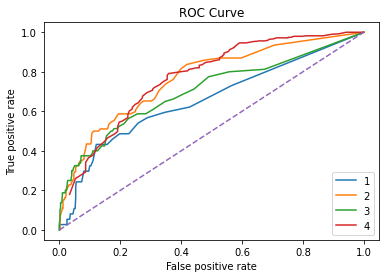

In [67]:
# Let's test roc function
model = RandomForestClassifier(n_estimators=100)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(xtrain, ytrain)
y_pred = model.predict(xtest)
y_predict_proba = model.predict_proba(xtest)
auc, roc_data = create_roc_all(ytest, y_predict_proba)

# Feature Engineering by Household and Individual features
Some columns are unique to the individual such as age, years of education, etc while other columns describe the individual's household characteristics. Additionally, the data set indicates what region the individual is in. A way to improve the model may be to see if there is any significance to how an individual's characteristics compare to others in the same geographic region. To do this, we will break down the data by region, scale each column, and build it back up into a data set for modeling.

In [68]:
locations = ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']
# Create a df that is grouped by household. Then split df by location.
df_hogar = df.groupby('idhogar').mean()
df_hogar

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,19.000000,4.0
003123ec2,0.0,3.0,0.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,12.750000,2.0
004616164,0.0,4.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.000000,2.0
004983866,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,37.500000,3.0
005905417,0.0,8.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,17.333333,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9343a35,0.0,5.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,39.500000,4.0
ff9d5ab17,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,19.666667,4.0
ffae4a097,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,61.000000,4.0


In [69]:
columns = ['abastaguadentro', 'abastaguafuera', 'abastaguano', 'age', 'area1', 'area2', 'bedrooms', 'cielorazo', 
           'computer', 'coopele', 'dependency', 'dis', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'epared1',
           'epared2', 'epared3', 'escolari', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 
           'estadocivil5', 'estadocivil6', 'estadocivil7', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 
           'eviv3', 'female', 'hacapo', 'hacdor', 'hhsize', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total',
           'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 
           'instlevel8', 'instlevel9', 'male', 'meaneduc', 'mobilephone', 'noelec', 'overcrowding', 'paredblolad', 
           'pareddes', 'paredfibras', 'paredmad', 'paredother', 'paredpreb', 'paredzinc', 'paredzocalo', 
           'parentesco1', 'parentesco10', 'parentesco11', 'parentesco12', 'parentesco2', 'parentesco3', 
           'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'pisocemento',
           'pisomadera', 'pisomoscer', 'pisonatur', 'pisonotiene', 'pisoother', 'planpri', 'public', 'qmobilephone',
           'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'refrig', 'rooms', 'sanitario1',
           'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6', 'tamhog', 'tamviv', 'techocane', 'techoentrepiso',
           'techootro', 'techozinc', 'television', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5',
           'v14a', 'v18q']

In [70]:
list_df_hogar = []

# for each location, remove it from the list, drop all columns in the list, put the location back in
# this creates a df without location information which is unnecessary

for i, location in enumerate(locations):
    locations.remove(location)
    df_hogar_lugar = df_hogar[df_hogar[location] == 1]
    df_hogar_lugar.drop(columns=locations, inplace=True)
    list_df_hogar += [df_hogar_lugar]
    locations.insert(i, location)
    
# For the df for each location, remove any columns containing location info ('lugar') as well as the Target column
for i, dff in enumerate(list_df_hogar):
    scaler = StandardScaler()
    cols_to_remove = list(dff.columns[dff.columns.str.startswith('lugar')])
    cols_to_remove += ['Target']
    columns = [column for column in columns if column not in cols_to_remove]

    data = dff.drop(cols_to_remove, axis=1).values

    scaler.fit(data)
    data = scaler.transform(data)

    list_df_hogar[i] = pd.DataFrame(data, columns = columns, index = dff.index)    

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [71]:
# Assemble all the dfs for each location into one mother df
df_all_scaled = pd.DataFrame()
for sub_df in list_df_hogar:
    df_all_scaled = df_all_scaled.append(sub_df)

df_all_scaled

,abastaguadentro,abastaguafuera,abastaguano,age,area1,area2,bedrooms,cielorazo,computer,coopele,...,techootro,techozinc,television,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,v14a,v18q
idhogar,,,,,,,,,,,,,,,,,,,,,
006031de3,-0.133862,-0.694791,-0.095755,0.067554,0.191029,1.601492,1.452043,-0.317069,0.448657,1.385337,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.927517
006555fe2,-0.133862,0.633686,-0.095755,0.067554,0.191029,-0.624418,-0.446285,1.838754,1.401715,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,1.449259,0.223807,1.028917,0.412431,-0.412431,1.014145
00693f597,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,0.760843,1.401715,-0.453079,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,0.337343,0.412431,-0.412431,-0.745661
009ae1cec,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,-1.394980,-0.504401,-0.453079,...,-0.500710,-0.12711,4.054090,-0.398187,-0.690008,0.223807,-1.045804,0.412431,-0.412431,-1.179318
00e3e05c5,-0.133862,-0.030553,-0.095755,0.067554,0.191029,-0.624418,1.452043,-0.317069,0.448657,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.880888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdb13f946,-0.148413,0.356007,-0.148413,0.065795,0.307148,2.943920,-0.528651,-0.407007,-0.644998,-0.543462,...,-0.407221,-0.09325,-0.370479,5.669467,-0.414388,0.162938,0.501829,-0.697982,0.697982,0.524503
fe30c653f,-0.148413,1.805017,-0.148413,0.065795,0.307148,-0.339683,1.064168,2.606574,2.855344,1.207693,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-0.893060
fef7fd222,-0.148413,0.356007,-0.148413,0.065795,0.307148,-0.339683,2.656987,-0.407007,1.105173,-0.543462,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-1.157351


In [73]:
df_hogar[locations].sum()/df_hogar[locations].sum().sum()
# 60% of households are in lugar1

lugar1    0.589357
lugar2    0.090361
lugar3    0.065930
lugar4    0.084003
lugar5    0.092704
lugar6    0.077644
dtype: float64

In [74]:
# Rename scaled columns before integrating into the main df
df_all_scaled.columns = df_all_scaled.columns.map(lambda x: x + '_scaledLugar')
df_all_scaled

,abastaguadentro_scaledLugar,abastaguafuera_scaledLugar,abastaguano_scaledLugar,age_scaledLugar,area1_scaledLugar,area2_scaledLugar,bedrooms_scaledLugar,cielorazo_scaledLugar,computer_scaledLugar,coopele_scaledLugar,...,techootro_scaledLugar,techozinc_scaledLugar,television_scaledLugar,tipovivi1_scaledLugar,tipovivi2_scaledLugar,tipovivi3_scaledLugar,tipovivi4_scaledLugar,tipovivi5_scaledLugar,v14a_scaledLugar,v18q_scaledLugar
idhogar,,,,,,,,,,,,,,,,,,,,,
006031de3,-0.133862,-0.694791,-0.095755,0.067554,0.191029,1.601492,1.452043,-0.317069,0.448657,1.385337,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.927517
006555fe2,-0.133862,0.633686,-0.095755,0.067554,0.191029,-0.624418,-0.446285,1.838754,1.401715,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,1.449259,0.223807,1.028917,0.412431,-0.412431,1.014145
00693f597,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,0.760843,1.401715,-0.453079,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,0.337343,0.412431,-0.412431,-0.745661
009ae1cec,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,-1.394980,-0.504401,-0.453079,...,-0.500710,-0.12711,4.054090,-0.398187,-0.690008,0.223807,-1.045804,0.412431,-0.412431,-1.179318
00e3e05c5,-0.133862,-0.030553,-0.095755,0.067554,0.191029,-0.624418,1.452043,-0.317069,0.448657,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.880888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdb13f946,-0.148413,0.356007,-0.148413,0.065795,0.307148,2.943920,-0.528651,-0.407007,-0.644998,-0.543462,...,-0.407221,-0.09325,-0.370479,5.669467,-0.414388,0.162938,0.501829,-0.697982,0.697982,0.524503
fe30c653f,-0.148413,1.805017,-0.148413,0.065795,0.307148,-0.339683,1.064168,2.606574,2.855344,1.207693,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-0.893060
fef7fd222,-0.148413,0.356007,-0.148413,0.065795,0.307148,-0.339683,2.656987,-0.407007,1.105173,-0.543462,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-1.157351


In [75]:
# Reintegrate columns into the original df_hogar
df_hogar = df_hogar.merge(df_all_scaled, on='idhogar')
df_hogar

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,techootro_scaledLugar,techozinc_scaledLugar,television_scaledLugar,tipovivi1_scaledLugar,tipovivi2_scaledLugar,tipovivi3_scaledLugar,tipovivi4_scaledLugar,tipovivi5_scaledLugar,v14a_scaledLugar,v18q_scaledLugar
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,-0.395831,-0.109985,-0.389071,-0.214087,-0.498755,0.181444,-1.109354,-0.869048,0.869048,-1.014576
003123ec2,0.0,3.0,0.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0,...,-0.410824,-0.121046,2.332780,-0.203355,-0.422757,0.172452,-0.258451,0.926855,-0.926855,-1.316898
004616164,0.0,4.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,...,-0.423130,-0.060971,3.201562,-0.174741,-0.464991,0.196116,-0.215941,-1.143544,1.143544,-0.348629
004983866,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.496825,-0.205738,-0.407039,-0.231249,-0.520546,0.191943,-0.159555,0.661783,-0.661783,0.036414
005905417,0.0,8.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,...,-0.395831,-0.109985,2.570226,-0.214087,-0.498755,0.181444,-1.109354,-0.869048,0.869048,-1.108097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9343a35,0.0,5.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,0.0,...,-0.500710,-0.127110,-0.246664,-0.398187,1.449259,0.223807,1.028917,0.412431,-0.412431,-0.032226
ff9d5ab17,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,2.434132,-0.121046,-0.428673,-0.203355,-0.422757,0.172452,-0.258451,0.926855,-0.926855,-0.917040
ffae4a097,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.407221,-0.093250,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,1.365431


Which columns are unique to individual and which should he share with household? In other words, which columns do you want to reassign to the household values (like living conditions) and which to keep for the individual (like age)?